# Samplot for SVs from GMM modes

## Imports

In [10]:
import boto3
import pysam
import os
from pathlib import Path
import pandas as pd
import tempfile
import ast
import multiprocessing as mp
from multiprocessing import Pool
import datetime
import numpy as np
#cpus = int(np.floor((mp.cpu_count()-1) /2))
from PIL import Image
import matplotlib.pyplot as plt
cpus = int(mp.cpu_count()-5)
print(cpus)

67


## Variants

In [11]:
os.chdir('/data/jake/sv-gmm/python')
sv_tbl='../data/sv-modes.tsv'
dirout='../data/2024_11_06-variants'
tmp='../tmp'
idx_1kg_phase3='../data/20130502.phase3.low_coverage.alignment.index' # from: aws s3 ls s3://1000genomes/alignment_indices/
if not os.path.exists(dirout):
    os.mkdir(dirout)

In [12]:
df = pd.read_csv(sv_tbl,sep='\t')
df.head()

,SV ID,# modes predicted,chr,start,stop,allele frequency,length,Total # samples,# reference samples,Mode 1,Mode 2,Mode 3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"['HG01125', 'HG01896', 'HG01956', 'HG02009', '...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"['HG00154', 'HG00159', 'HG00250', 'HG00264', '...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"['HG00180', 'HG00185', 'HG00189', 'HG00237', '...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"['HG00114', 'HG00132', 'HG00142', 'HG00150', '...","['HG00108', 'HG00111', 'HG00121', 'HG00125', '...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"['HG01241', 'HG01259', 'HG01488', 'HG01890', '...","['HG01125', 'HG01392', 'HG01403', 'HG01556', '...",NaN


In [13]:
df.columns = ['id', 'n_modes', 'chr', 'start', 'stop', 'allele_freq', 'length', 'n_samples', 'n_ref_samples', 'mode_1', 'mode_2', 'mode_3']
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"['HG01125', 'HG01896', 'HG01956', 'HG02009', '...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"['HG00154', 'HG00159', 'HG00250', 'HG00264', '...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"['HG00180', 'HG00185', 'HG00189', 'HG00237', '...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"['HG00114', 'HG00132', 'HG00142', 'HG00150', '...","['HG00108', 'HG00111', 'HG00121', 'HG00125', '...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"['HG01241', 'HG01259', 'HG01488', 'HG01890', '...","['HG01125', 'HG01392', 'HG01403', 'HG01556', '...",NaN


In [14]:
# mode columns were parsed as strings, not lists
df['mode_1'] = df['mode_1'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df['mode_2'] = df['mode_2'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df['mode_3'] = df['mode_3'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else x)
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN


In [15]:
# pad start and end for region queries (start=start-length, stop=stop+length)
df['p_start'] = df.apply(lambda row: row['start'] - ( 1000 * row['length']),axis=1)
df['p_stop'] = df.apply(lambda row: row['stop'] + ( 1000 * row['length']),axis=1)
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3,p_start,p_stop
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN,53871338,55904354
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN,86177825,87426449
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN,174279474,180312489
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN,45184612,45574612
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN,136764507,137228739


In [16]:
variants=df.id.tolist()
variants

['UW_VH_9038',
 'SI_BD_10797',
 'UW_VH_19141',
 'DEL_pindel_47187',
 'DEL_pindel_24042',
 'BI_GS_DEL1_B2_P0106_507',
 'BI_GS_DEL1_B4_P2674_173',
 'UW_VH_10394',
 'BI_GS_DEL1_B2_P0114_484']

## Download bams

Certain pysam versions fail to get region BAMs from s3. The conda 3.7 env used for samplot will not work. Instead use /data/jake/miniconda env.

In [17]:
# output dirs 
# variant_name/
# |
# l_ samplot/
# l_ bam/
for v in variants:
    d = os.path.join(dirout,v)
    if not os.path.exists(d):
        os.mkdir(d)
    d_bam = os.path.join(dirout,v,'bam')
    d_samplot = os.path.join(dirout,v,'samplot')
    if not os.path.exists(d_bam):
        os.mkdir(d_bam)
    if not os.path.exists(d_samplot):
        os.mkdir(d_samplot)

From ftp.1000genomes.ebi.ac.uk:/vol1/ftp/phase3/20130502.phase3.low_coverage.alignment.index

Example

```
# login as "anonymous"
ftp ftp.1000genomes.ebi.ac.uk
cd vol1/ftp/phase3
get 20130502.phase3.low_coverage.alignment.index
```


In [18]:
# # filter index file for mapped reads only
# paths = pd.read_csv(idx_1kg_phase3,sep='\t').iloc[:,0]
# print(paths.shape)
# mask = paths.str.contains(r'\.mapped\.ILLUMINA.*bam$',regex=True)
# mapped = paths[mask]
# print(mapped.shape)
# mapped.head()
mapped_index = '../data/1kg_phase3_mapped.index'
# mapped.to_csv('../data/1kg_phase3_mapped.index', header=False,index=False)

In [19]:
pd.read_csv(mapped_index,header=None, usecols=[0]).iloc[:,0]

0       data/HG00096/alignment/HG00096.mapped.ILLUMINA...
1       data/HG00097/alignment/HG00097.mapped.ILLUMINA...
2       data/HG00099/alignment/HG00099.mapped.ILLUMINA...
3       data/HG00100/alignment/HG00100.mapped.ILLUMINA...
4       data/HG00101/alignment/HG00101.mapped.ILLUMINA...
                              ...                        
2530    data/NA21137/alignment/NA21137.mapped.ILLUMINA...
2531    data/NA21141/alignment/NA21141.mapped.ILLUMINA...
2532    data/NA21142/alignment/NA21142.mapped.ILLUMINA...
2533    data/NA21143/alignment/NA21143.mapped.ILLUMINA...
2534    data/NA21144/alignment/NA21144.mapped.ILLUMINA...
Name: 0, Length: 2535, dtype: object

In [20]:
# old
#def download_1kg_bam_region(
#    index_file,
#    sample,
#    chrom,
#    left,
#    right,
#    out,
#    bucket='1000genomes',
#    phase='phase3',
#    tmp='/data/jake/sv-gmm/tmp'
#):
#    print('index_file:',index_file,'sample:',sample,'left:',left,'right:',right,'out:',out)
#    index_series = pd.read_csv(mapped_index,header=None).iloc[:,0]
#    chrom = str(chrom)
#    left = int(left)
#    right = int(right)
#
#    # filter index for sample
#    mask = index_series.str.contains(sample)
#    if bool(mask.sum() > 1):
#        raise ValueError("sample name matched more than one file in index")
#    key_bam = index_series[mask].tolist()[0]
#    print('key_bam:',key_bam)
#    key_bam = os.path.join(phase, key_bam) # e.g., phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
#    key_bai = key_bam + '.bai'
#    # url
#    url_bam = os.path.join(
#        's3://', bucket, key_bam # e.g., s3://1000genomes/phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
#    )
#    # out
#    region_bam=out + '.bam'
#
#    s3.download_file(bucket, key_bai, os.path.join(tmp,key_bai))
#    # download full bam index temporarily, necessary to 
#    # get region bam
#    ### try without tempfile
#    with tempfile.NamedTemporaryFile(delete=True) as temp_file:
#        # s3 dl
#        s3 = boto3.client('s3')
#        s3.download_fileobj(bucket, key_idx, temp_file)
#        print('temp index at:', temp_file.name)
#        # ensure pointer is at beginning of file for pysam reading
#        # (likely not necessary)
#        #temp_file.seek(0)
#        print(url_bam)
#
#        # read server bam with local index (may be able to use remote index, not sure)
#        with pysam.AlignmentFile(url_bam, "rb", index_filename=temp_file.name) as f_in:
#            print('writing region bam at:', region_bam)
#            with pysam.AlignmentFile(region_bam, "wb", header=f_in.header) as f_out:
#                print(chrom,left,right)
#                for read in f_in.fetch(str(chrom), left, right):
#                    f_out.write(read)
#        # index region bam
#        print('indexing', region_bam)
#        pysam.index(region_bam)
#    return None
#download_1kg_bam_region(mapped_index,"HG01125",19,54886338,54889354,'../test')
#        

In [21]:
#v2
def download_1kg_bam_region(
    index_file,
    sample,
    chrom,
    left,
    right,
    out,
    bucket='1000genomes',
    phase='phase3',
    tmp='/data/jake/sv-gmm/tmp'
):
    print('index_file:',index_file,'sample:',sample,'left:',left,'right:',right,'out:',out)
    index_series = pd.read_csv(mapped_index,header=None).iloc[:,0]
    chrom = str(chrom)
    left = int(left)
    right = int(right)

    # filter index for sample
    mask = index_series.str.contains(sample)
    if bool(mask.sum() > 1):
        raise ValueError("sample name matched more than one file in index")
    key_bam = index_series[mask].tolist()[0]
    print('key_bam:',key_bam)
    key_bam = os.path.join(phase, key_bam) # e.g., phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
    key_bai = key_bam + '.bai'
    # url
    url_bam = os.path.join(
        's3://', bucket, key_bam # e.g., s3://1000genomes/phase3/data/HG01125/alignment/HG01125.mapped.ILLUMINA.bwa.CLM.low_coverage.20120522.bam
    )
    # out
    region_bam=out + '.bam'
    print('region_bam', region_bam)
    # full idx goes to tmp
    s3 = boto3.client('s3')
    full_idx=os.path.join(tmp,os.path.basename(key_bai))
    s3.download_file(bucket, key_bai, full_idx)

    ## Use pysam's remote access capability
    with pysam.AlignmentFile(url_bam, "rb", index_filename=full_idx) as f_in:
        with pysam.AlignmentFile(region_bam, "wb", header=f_in.header) as f_out:
            for read in f_in.fetch(chrom, left, right):
                f_out.write(read)
    pysam.index(region_bam)
    return None
# run this to download single bam file
#download_1kg_bam_region(mapped_index,"HG01125",19,54886338,54889354,'test')
        

In [22]:
df.head()

,id,n_modes,chr,start,stop,allele_freq,length,n_samples,n_ref_samples,mode_1,mode_2,mode_3,p_start,p_stop
0,UW_VH_9038,1,19,54887338,54888354,0.014,1016,51,0,"[HG01125, HG01896, HG01956, HG02009, HG02108, ...",NaN,NaN,53871338,55904354
1,SI_BD_10797,1,10,86801825,86802449,0.033,624,283,139,"[HG00154, HG00159, HG00250, HG00264, HG00737, ...",NaN,NaN,86177825,87426449
2,UW_VH_19141,1,3,177294474,177297489,0.032,3015,133,1,"[HG00180, HG00185, HG00189, HG00237, HG00254, ...",NaN,NaN,174279474,180312489
3,DEL_pindel_47187,2,18,45379612,45379612,0.550,195,847,66,"[HG00114, HG00132, HG00142, HG00150, HG00272, ...","[HG00108, HG00111, HG00121, HG00125, HG00138, ...",NaN,45184612,45574612
4,DEL_pindel_24042,2,7,136996507,136996739,0.071,232,184,48,"[HG01241, HG01259, HG01488, HG01890, HG02054, ...","[HG01125, HG01392, HG01403, HG01556, HG01845, ...",NaN,136764507,137228739


In [23]:
# setup download queries for each variant, mode, and sample
queries = {'sample': [], 'chrom': [], 'p_start':[], 'p_stop':[], 'fname':[]}
for i,row in df.iterrows():
    variant = row['id']
    chrom = row['chr']
    start = row['start']
    stop = row['stop']
    p_start = row['p_start']
    p_stop = row['p_stop']
    data = pd.DataFrame({'sample':[], 'mode':[]})
    for m in ['mode_1', 'mode_2', 'mode_3']:
        if isinstance(row[m], list):
            for s in row[m]:
                data = pd.concat([data, pd.DataFrame({'sample': [s], 'mode': [m]})])
        elif pd.isnull((row[m])):
            print(f'no {m} for {variant}')
        else:
            raise ValueError
    for j, r in data.iterrows():
        sample = r['sample']
        mode = r['mode']
        #queries['variant'].append(variant)
        queries['sample'].append(sample)
        #queries['mode'].append(mode)
        queries['chrom'].append(chrom)
        queries['p_start'].append(p_start)
        queries['p_stop'].append(p_stop)
        queries['fname'].append(os.path.join(dirout,variant,'bam', f'{variant}.{mode}.{sample}.{chrom}.{start}.{stop}'))
    

no mode_2 for UW_VH_9038
no mode_3 for UW_VH_9038
no mode_2 for SI_BD_10797
no mode_3 for SI_BD_10797
no mode_2 for UW_VH_19141
no mode_3 for UW_VH_19141
no mode_3 for DEL_pindel_47187
no mode_3 for DEL_pindel_24042


In [24]:
df_query = pd.DataFrame(queries)
df_query.insert(0, 'index', mapped_index)
df_query.head()

,index,sample,chrom,p_start,p_stop,fname
0,../data/1kg_phase3_mapped.index,HG01125,19,53871338,55904354,../data/2024_11_06-variants/UW_VH_9038/bam/UW_...
1,../data/1kg_phase3_mapped.index,HG01896,19,53871338,55904354,../data/2024_11_06-variants/UW_VH_9038/bam/UW_...
2,../data/1kg_phase3_mapped.index,HG01956,19,53871338,55904354,../data/2024_11_06-variants/UW_VH_9038/bam/UW_...
3,../data/1kg_phase3_mapped.index,HG02009,19,53871338,55904354,../data/2024_11_06-variants/UW_VH_9038/bam/UW_...
4,../data/1kg_phase3_mapped.index,HG02108,19,53871338,55904354,../data/2024_11_06-variants/UW_VH_9038/bam/UW_...


In [25]:
df_query['fname'][0]

'../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54887338.54888354'

In [32]:
# list of tuples for starmap
tuples_list = [row for row in df_query.itertuples(index=False, name=None)]
tuples_list[0:5]

[('../data/1kg_phase3_mapped.index',
  'HG01125',
  19,
  53871338,
  55904354,
  '../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54887338.54888354'),
 ('../data/1kg_phase3_mapped.index',
  'HG01896',
  19,
  53871338,
  55904354,
  '../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01896.19.54887338.54888354'),
 ('../data/1kg_phase3_mapped.index',
  'HG01956',
  19,
  53871338,
  55904354,
  '../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01956.19.54887338.54888354'),
 ('../data/1kg_phase3_mapped.index',
  'HG02009',
  19,
  53871338,
  55904354,
  '../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG02009.19.54887338.54888354'),
 ('../data/1kg_phase3_mapped.index',
  'HG02108',
  19,
  53871338,
  55904354,
  '../data/2024_11_06-variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG02108.19.54887338.54888354')]

### Parallel download

In [33]:
# single process
#for t in tuples_list:
        #download_1kg_bam_region(*t)
# parallel
print(str(datetime.datetime.now()))
with Pool(processes=cpus) as pool:
        results = pool.starmap(download_1kg_bam_region, tuples_list)
print(str(datetime.datetime.now()))

2024-11-06 12:53:26.035814


index_file:index_file:index_file:index_file:index_file:index_file: index_file:index_file: index_file:index_file:index_file:  index_file:index_file: index_file:index_file: index_file:index_file:index_file:../data/1kg_phase3_mapped.indexindex_file:index_file:index_file:  ../data/1kg_phase3_mapped.indexindex_file:  ../data/1kg_phase3_mapped.index ../data/1kg_phase3_mapped.indexindex_file:index_file:index_file:  ../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.indexindex_file:    ../data/1kg_phase3_mapped.index index_file: index_file:     index_file:index_file: index_file:../data/1kg_phase3_mapped.index../data/1kg_phase3_mapped.indexindex_file: ../data/1kg_phase3_mapped.indexindex_file:../data/1kg_phase3_mapped.indexindex_file:index_file:index_file:index_file:  index_file:../data/1kg_phase3_mapped.index ../data/1kg_phase3_mapped.indexindex_file:index_file:index_file:  index_file:sample:../data/1kg_phase3_mapped.indexindex_file:../data/1kg_phase3_mapped.index index_file:index_file: 

## Samplot

Using a python 3.7 based conda environment

```
conda install samplot
```

### Setup

In [29]:
os.getcwd()

'/data/jake/sv-gmm/python'

In [27]:
# samplot plot -n HG01125 -b region-pad.bam -t DEL -s 54887338 -e 54888354 -c chr19 -o region-pad.png -r grch37.fa
def samplot(sample, bam, chrm, start, end,  type, outfile):
    cmd = 'samplot plot -n {} -b {} -t {} -s {} -e {} -c {} -o {}'.format(sample, bam, type, start, end, chrm, outfile)
    os.system(cmd)
# test
samplot('HG01125', '../data/variants/UW_VH_9038/bam/UW_VH_9038.mode_1.HG01125.19.54886322.54889370.bam', 'chr19', 54886338, 54889354, 'DEL', 'test.png')

Insufficient reads for fragment length estimate.
Continuing with unmodified window size


In [30]:
variants = [os.path.join(dirout, x, 'bam') for x in os.listdir(dirout)]
print(variants)
s = os.listdir(variants[4])[0:5]
print(s)

['../data/2024_11_06-variants/DEL_pindel_24042/bam', '../data/2024_11_06-variants/BI_GS_DEL1_B4_P2674_173/bam', '../data/2024_11_06-variants/UW_VH_10394/bam', '../data/2024_11_06-variants/UW_VH_19141/bam', '../data/2024_11_06-variants/UW_VH_9038/bam', '../data/2024_11_06-variants/BI_GS_DEL1_B2_P0114_484/bam', '../data/2024_11_06-variants/BI_GS_DEL1_B2_P0106_507/bam', '../data/2024_11_06-variants/SI_BD_10797/bam', '../data/2024_11_06-variants/DEL_pindel_47187/bam']
['UW_VH_9038.mode_1.HG03139.19.54887338.54888354.bam.bai', 'UW_VH_9038.mode_1.HG03196.19.54887338.54888354.bam', 'UW_VH_9038.mode_1.HG03111.19.54887338.54888354.bam.bai', 'UW_VH_9038.mode_1.HG02332.19.54887338.54888354.bam', 'UW_VH_9038.mode_1.NA19026.19.54887338.54888354.bam']


In [31]:
root_dir = Path(dirout) 

bams= []
for file_path in root_dir.rglob('bam/*.bam'):
    bams.append(str(file_path))
print(bams[0],bams[-1])

../data/2024_11_06-variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG03378.7.136996507.136996739.bam ../data/2024_11_06-variants/DEL_pindel_47187/bam/DEL_pindel_47187.mode_1.NA19445.18.45379612.45379612.bam


In [32]:
df_samplot = pd.DataFrame({'sample':[], 'bam':[], 'chrm':[], 'start':[], 'end':[], 'type':[], 'outfile':[]})
for b in bams:
    basename = os.path.basename(b)
    mode = basename.split('.')[1]
    sample = basename.split('.')[2]
    chrm = basename.split('.')[3]
    start = basename.split('.')[4]
    end = basename.split('.')[5]
    type = 'DEL'
    outfile = b.replace('.bam','.png').replace('bam','samplot')
    df_samplot = pd.concat([df_samplot, pd.DataFrame({'sample': [sample], 'bam': [b], 'chrm': [chrm], 'start': [start], 'end': [end], 'type': [type], 'outfile': [outfile]})])
print(df_samplot.shape)
print(df_samplot.iloc[0,:]['bam'])
print(df_samplot.iloc[0,:]['outfile'])
df_samplot.head()


(2281, 7)
../data/2024_11_06-variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG03378.7.136996507.136996739.bam
../data/2024_11_06-variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG03378.7.136996507.136996739.png


,sample,bam,chrm,start,end,type,outfile
0,HG03378,../data/2024_11_06-variants/DEL_pindel_24042/b...,7,136996507,136996739,DEL,../data/2024_11_06-variants/DEL_pindel_24042/s...
0,HG01915,../data/2024_11_06-variants/DEL_pindel_24042/b...,7,136996507,136996739,DEL,../data/2024_11_06-variants/DEL_pindel_24042/s...
0,HG02356,../data/2024_11_06-variants/DEL_pindel_24042/b...,7,136996507,136996739,DEL,../data/2024_11_06-variants/DEL_pindel_24042/s...
0,HG01403,../data/2024_11_06-variants/DEL_pindel_24042/b...,7,136996507,136996739,DEL,../data/2024_11_06-variants/DEL_pindel_24042/s...
0,HG01845,../data/2024_11_06-variants/DEL_pindel_24042/b...,7,136996507,136996739,DEL,../data/2024_11_06-variants/DEL_pindel_24042/s...


In [33]:
# list of tuples for starmap
tuples_list = [row for row in df_samplot.itertuples(index=False, name=None)]
tuples_list[0:3]

[('HG03378',
  '../data/2024_11_06-variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG03378.7.136996507.136996739.bam',
  '7',
  '136996507',
  '136996739',
  'DEL',
  '../data/2024_11_06-variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG03378.7.136996507.136996739.png'),
 ('HG01915',
  '../data/2024_11_06-variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG01915.7.136996507.136996739.bam',
  '7',
  '136996507',
  '136996739',
  'DEL',
  '../data/2024_11_06-variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG01915.7.136996507.136996739.png'),
 ('HG02356',
  '../data/2024_11_06-variants/DEL_pindel_24042/bam/DEL_pindel_24042.mode_2.HG02356.7.136996507.136996739.bam',
  '7',
  '136996507',
  '136996739',
  'DEL',
  '../data/2024_11_06-variants/DEL_pindel_24042/samplot/DEL_pindel_24042.mode_2.HG02356.7.136996507.136996739.png')]

### Plot

In [34]:
with Pool(processes=cpus) as pool:
        results = pool.starmap(samplot, tuples_list)

Window size is under 1.5x the estimated fragment length and will be resized to 703. Rerun with -w 116 to override
Window size is under 1.5x the estimated fragment length and will be resized to 687. Rerun with -w 232 to override
Window size is under 1.5x the estimated fragment length and will be resized to 690. Rerun with -w 116 to override
Window size is under 1.5x the estimated fragment length and will be resized to 699. Rerun with -w 232 to override
Window size is under 1.5x the estimated fragment length and will be resized to 720. Rerun with -w 232 to override
Window size is under 1.5x the estimated fragment length and will be resized to 705. Rerun with -w 116 to override
Window size is under 1.5x the estimated fragment length and will be resized to 549. Rerun with -w 116 to override
Window size is under 1.5x the estimated fragment length and will be resized to 544. Rerun with -w 508 to override
Window size is under 1.5x the estimated fragment length and will be resized to 684. Reru

### Analysis

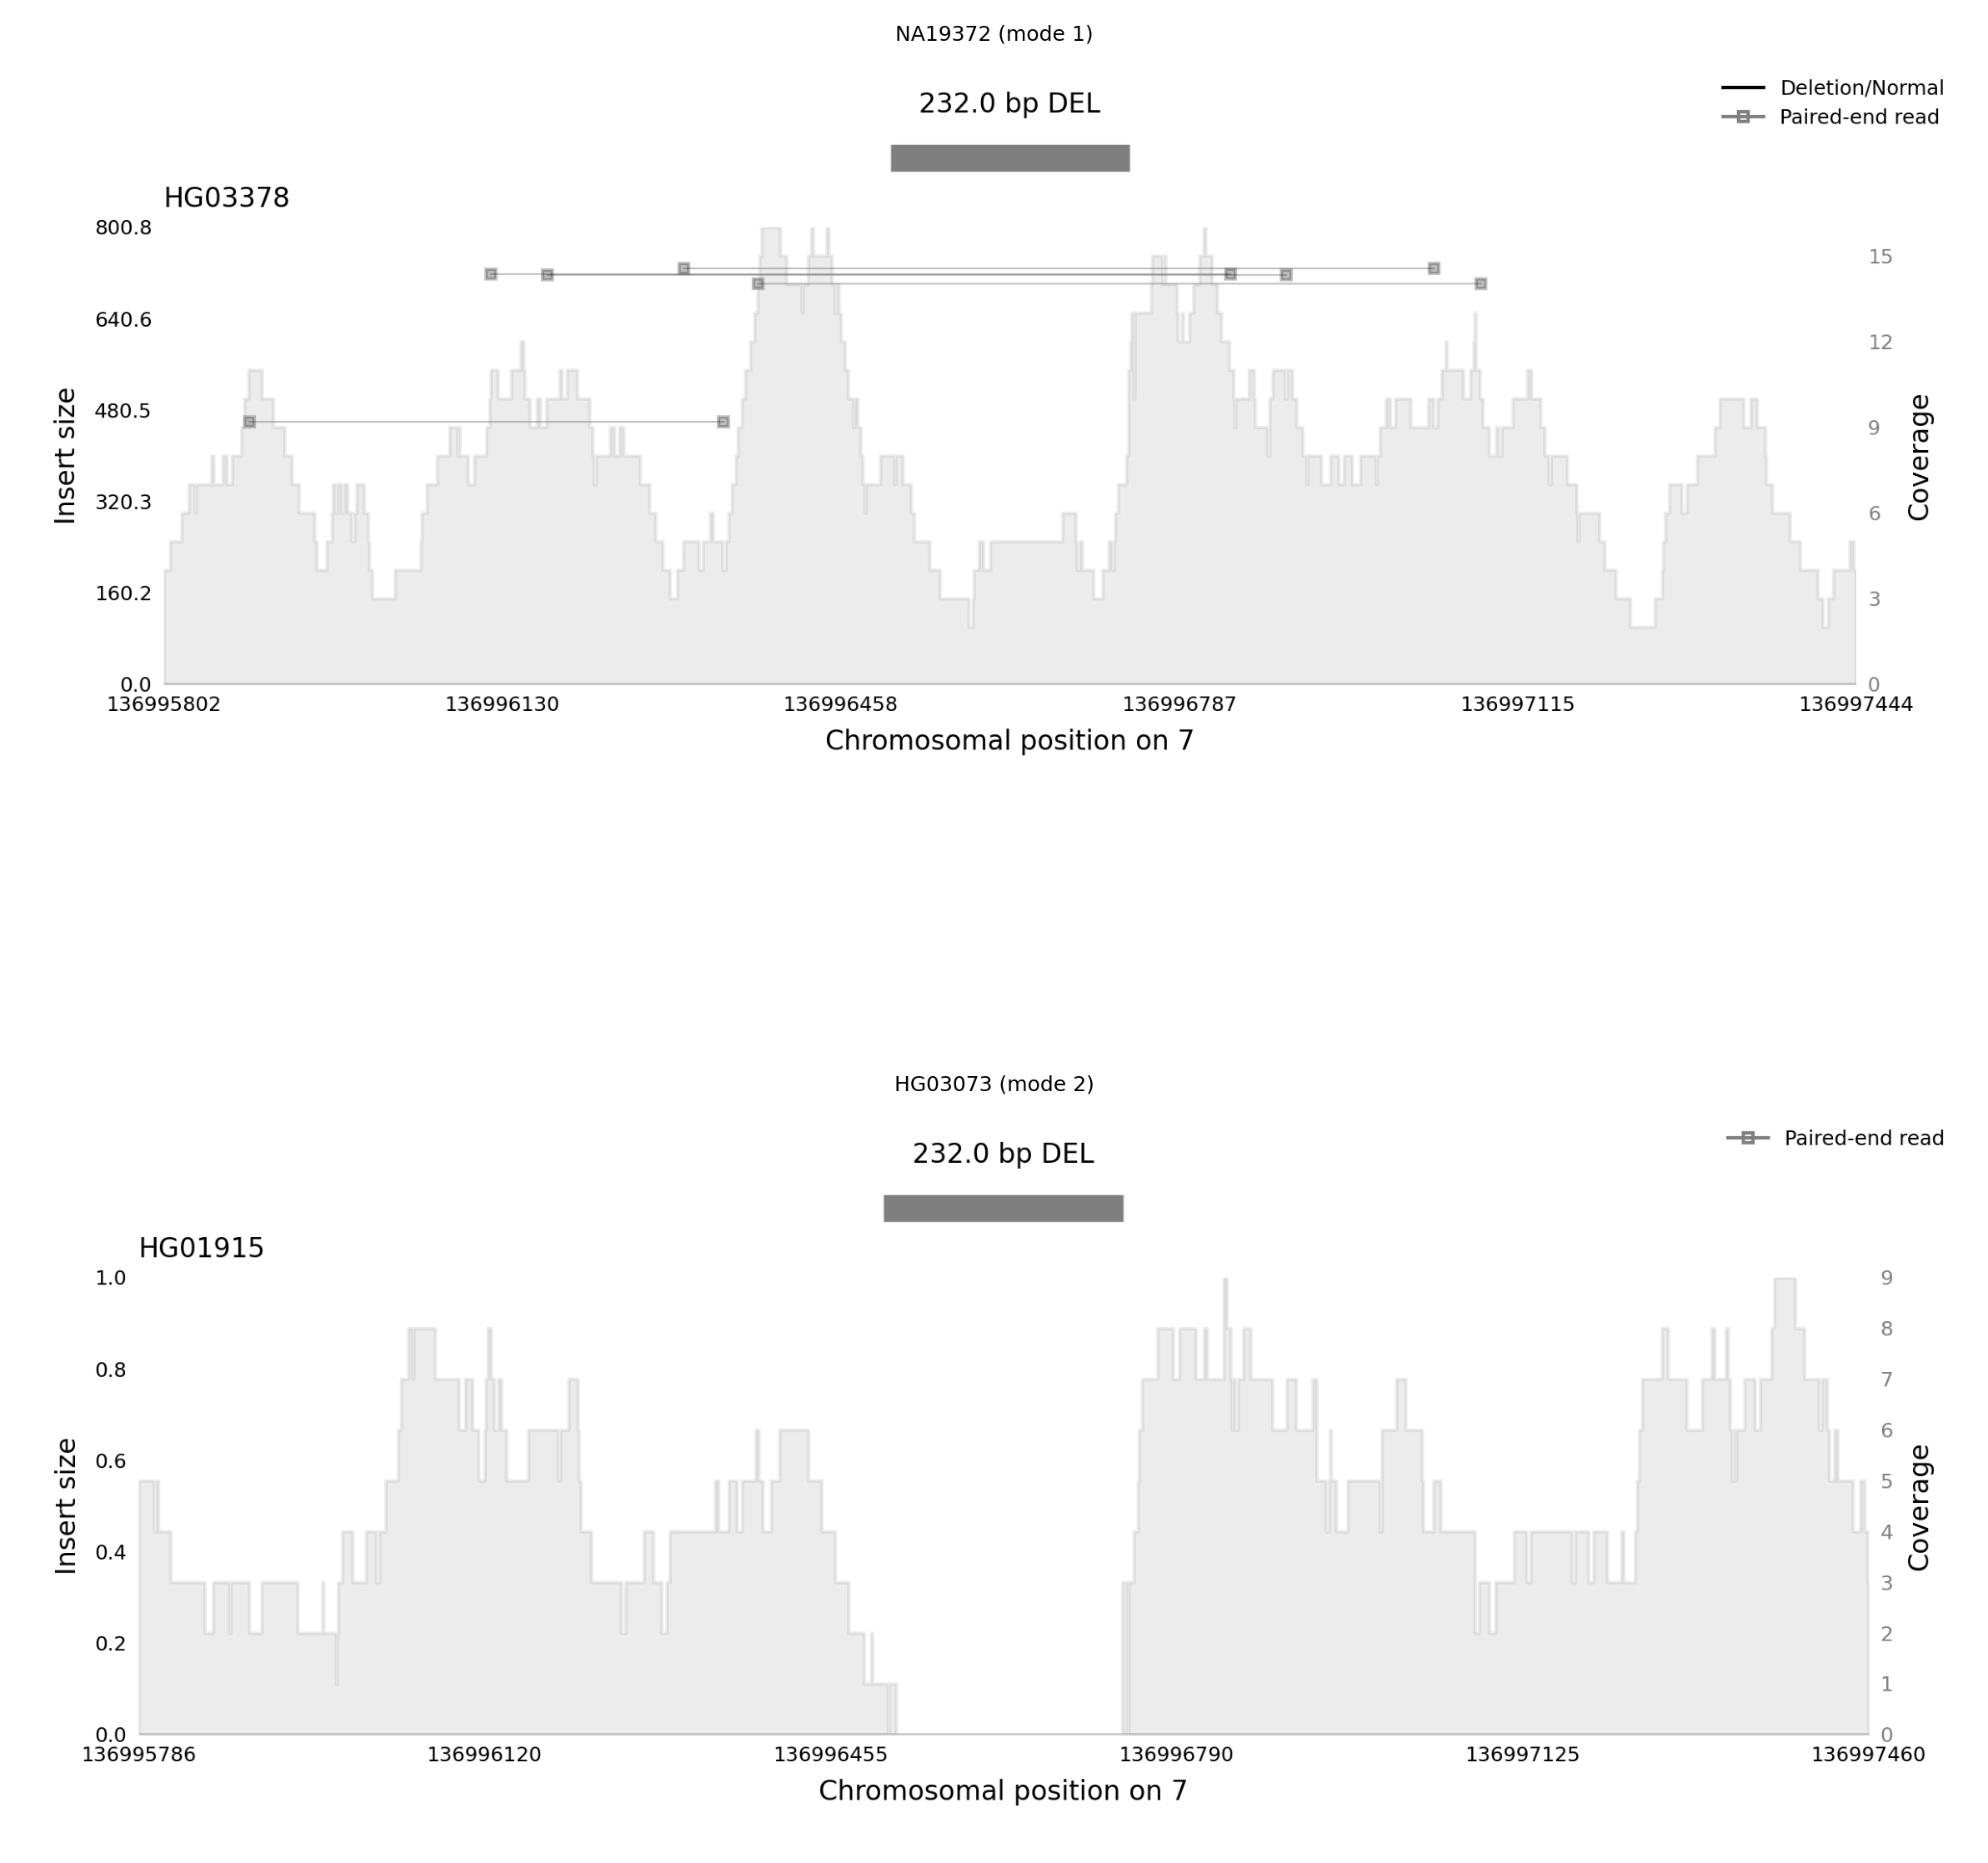

In [35]:
def varmodes2subplots(image_paths, titles, save = None):
    if len(image_paths) != len(titles):
        raise ValueError('number of images must match number of titles')
    
    images = [Image.open(x) for x in image_paths]

    fig = plt.figure(figsize=(10, 10), dpi=300)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(len(images), 1, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=6)
        plt.axis('off') 
    
    if save:
        plt.savefig(save)
    plt.close()
    return fig

# def varmodes2subplots(image_paths, titles):
#     if len(image_paths) != len(titles):
#         raise ValueError('number of images must match number of titles')
#     images = [Image.open(x) for x in image_paths]

#     plt.figure(figsize=(10, 10),dpi=300)
#     for i, (img, title) in enumerate(zip(images, titles)):
#         plt.subplot(1, len(images), i+1)
#         plt.imshow(img)
#         plt.title(title, fontsize =6)
#     return plt
fig = varmodes2subplots([df_samplot.iloc[0,:]['outfile'], df_samplot.iloc[1,:]['outfile']], ['NA19372 (mode 1)', 'HG03073 (mode 2)'],save='test.png')
fig

#### Plot randomly selected samples for different modes from the same variant

In [50]:
pngs = pd.DataFrame(df_samplot.bam.apply(lambda x: x.replace('.bam','.png')))
pngs['variant'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[0])
pngs['sample'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[2])
pngs['mode'] = pngs['bam'].apply(lambda x: os.path.basename(x).split('.')[1])
pngs.sort_values(['variant', 'mode'], inplace=True)
print(pngs.shape)
pngs.head()

(2281, 4)


,bam,variant,sample,mode
0,../data/2024_11_06-variants/BI_GS_DEL1_B2_P010...,BI_GS_DEL1_B2_P0106_507,NA18645,mode_1
0,../data/2024_11_06-variants/BI_GS_DEL1_B2_P010...,BI_GS_DEL1_B2_P0106_507,NA18574,mode_2
0,../data/2024_11_06-variants/BI_GS_DEL1_B2_P010...,BI_GS_DEL1_B2_P0106_507,NA18988,mode_2
0,../data/2024_11_06-variants/BI_GS_DEL1_B2_P010...,BI_GS_DEL1_B2_P0106_507,HG02385,mode_3
0,../data/2024_11_06-variants/BI_GS_DEL1_B2_P010...,BI_GS_DEL1_B2_P0106_507,HG01841,mode_3


>1 mode found for variant DEL_pindel_24042
mode_1
mode_2


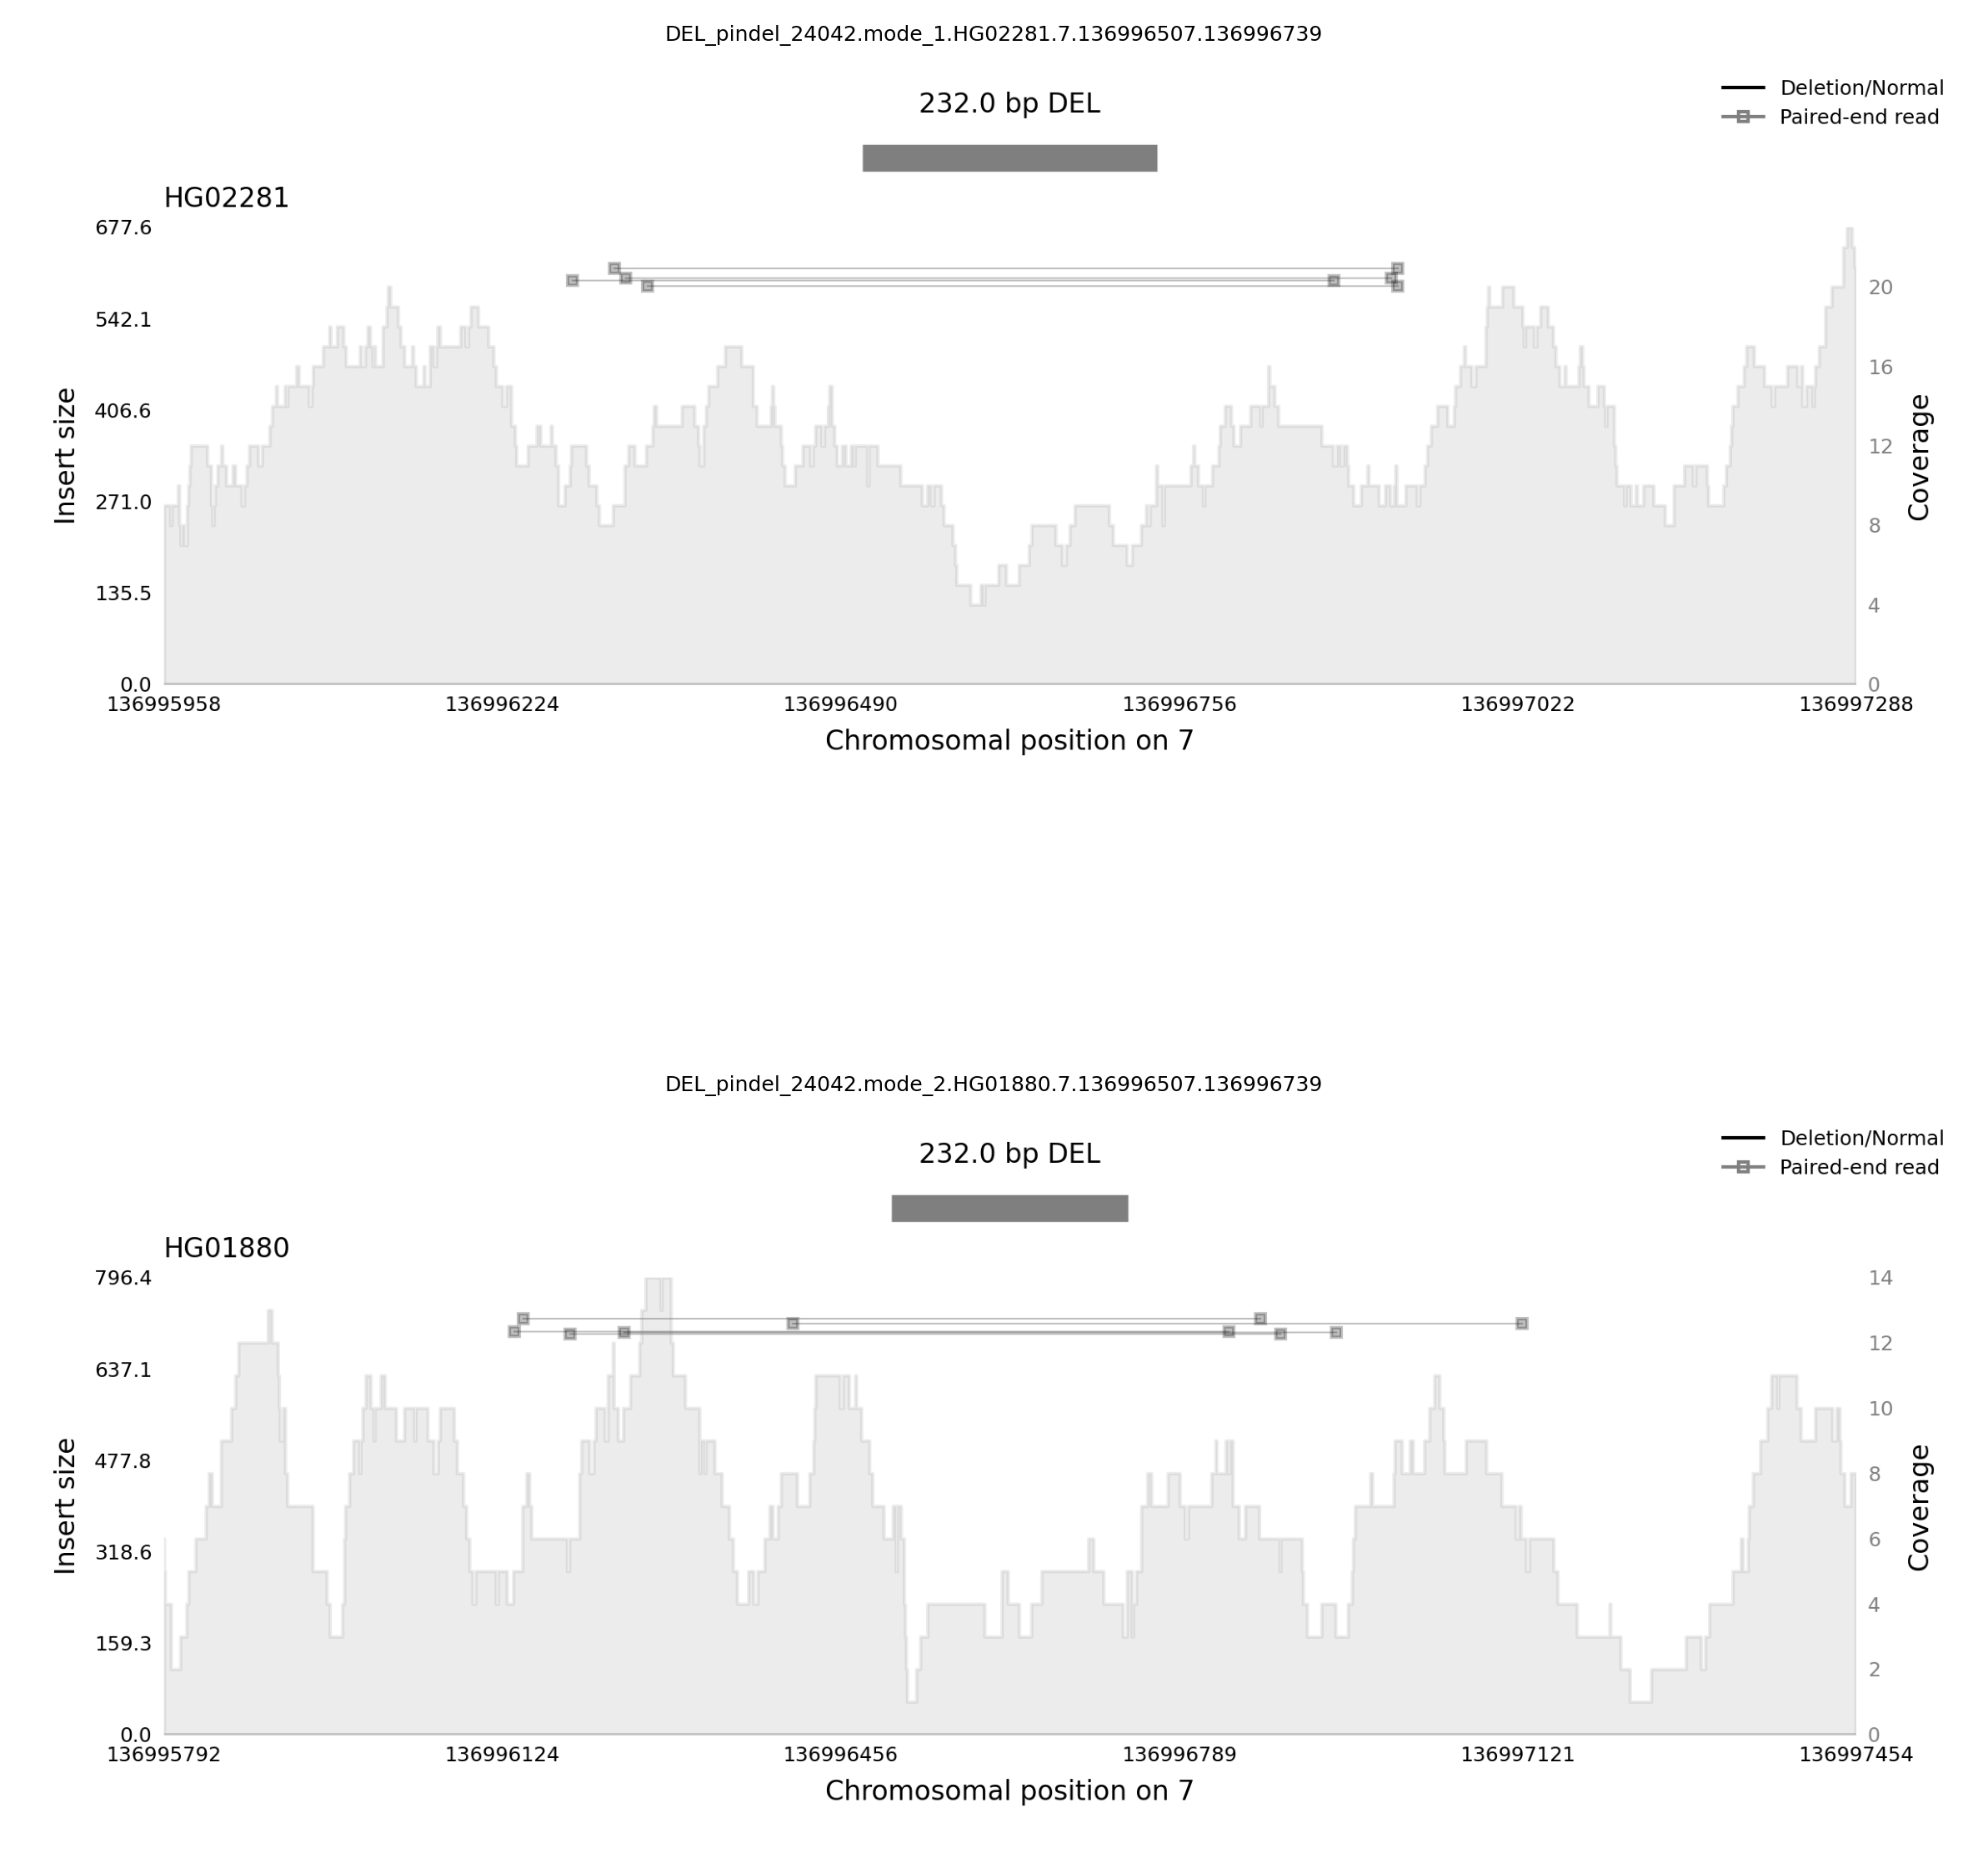

In [55]:
def random_samples(df_pngs, variant,seed=None):
    df_pngs = df_pngs[df_pngs.variant == variant]
    groups = df_pngs.groupby('mode')
    if (len(groups) == 0):
        raise ValueError(f"No data found for variant {variant}")
    elif (len(groups)==1):
        print('warning: only one mode found for variant', variant)
    else:
        print('>1 mode found for variant', variant)
    random_paths = []
    titles = []
    for mode, df in groups:
        print(mode)
        if seed:
            rsample = df.sample(1, random_state=seed)
        else:
            
            rsample = df.sample(1)
        path = rsample['bam'].values[0]
        path = path.replace('bam','samplot')
        title = str(Path(os.path.basename(path)).stem)
        random_paths.append(path)
        titles.append(title)
    return random_paths, titles
paths, titles = random_samples(pngs, 'DEL_pindel_24042')
varmodes2subplots(paths, titles)

#    paired_images(pngs_var.iloc[0,:]['bam'], pngs_var.iloc[1,:]['bam'])

In [57]:
variant_l = pngs.variant.unique().tolist()
variant_l

['BI_GS_DEL1_B2_P0106_507',
 'BI_GS_DEL1_B2_P0114_484',
 'BI_GS_DEL1_B4_P2674_173',
 'DEL_pindel_24042',
 'DEL_pindel_47187',
 'SI_BD_10797',
 'UW_VH_10394',
 'UW_VH_19141',
 'UW_VH_9038']

In [60]:
dirpng='../fig'
figs = []
for v in variant_l:
    i = 0
    while i < 3:
        paths, titles = random_samples(pngs, v, seed=i)
        outfile = os.path.join(dirpng,'-'.join(titles) + '.png')
        if os.path.exists(outfile):
            continue
        print(outfile)
        figs.append(varmodes2subplots(paths, titles, save = outfile))
        i += 1


>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_2.NA18574.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_3.HG02373.1.105832822.105844373.png
>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_2.NA18574.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_3.HG00566.1.105832822.105844373.png
>1 mode found for variant BI_GS_DEL1_B2_P0106_507
mode_1
mode_2
mode_3
../fig/BI_GS_DEL1_B2_P0106_507.mode_1.NA18645.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_2.NA18988.1.105832822.105844373-BI_GS_DEL1_B2_P0106_507.mode_3.HG03603.1.105832822.105844373.png
>1 mode found for variant BI_GS_DEL1_B2_P0114_484
mode_1
mode_2
mode_3
../fig/BI_GS_DEL1_B2_P0114_484.mode_1.NA19788.1.113799624.113800089-BI_GS_DEL1_B2_P0114_484.mode_2.NA19764.1.113799624.113800089-BI_GS

#### Aggregate

In [62]:
from PIL import Image
import os

def pngs_to_pdf(png_files, output_pdf):
    # Open the first image and convert it to RGB (necessary for saving as PDF)
    first_image = Image.open(png_files[0]).convert('RGB')
    
    # Create a list for the rest of the images
    images = []
    
    # Loop through the remaining PNG files
    for png_file in png_files[1:]:
        img = Image.open(png_file).convert('RGB')
        images.append(img)

    # Save all images as a single PDF
    first_image.save(output_pdf, save_all=True, append_images=images)

# Example usage
output_pdf = 'all.pdf'  # Desired output PDF file name

pngs_to_pdf([os.path.join(dirpng, x) for x in os.listdir(dirpng)], output_pdf)